# Regional European Daily SST (OSTIA) Analysis: Identifying Marine Extremes with `MarEx-Detect`

**MarEx-Detect** transforms raw oceanographic time series into standardised extreme event boolean datasets through a four-stage processing pipeline optimised for **high-resolution regional climate data**.

This example demonstrates preprocessing of **full-resolution OSTIA data** (0.05°) for the European region, covering:
- **Atlantic Ocean** around UK and Ireland 
- **North Sea** and Baltic Sea
- **Mediterranean Sea** and Black Sea (partial)
- **Regional domain**: 20°N-65°N, 20°W-40°E

---

## Processing Stages

### 1. Anomaly Computation
Choose between two methodological approaches for calculating **anomalies**:

**Shifting Baseline** *(scientifically rigorous)*  
- Computes anomalies relative to backward-looking rolling climatology using previous N years of data
- More accurate representation of baseline conditions but computationally expensive
- Shortens usable time series by window duration

**Detrended Baseline** *(computationally efficient)*  
- Removes trends and seasonal cycles using harmonic decomposition (mean + annual/semi-annual harmonics + polynomial trends)
- Efficient processing but may introduce statistical biases in certain metrics

### 2. Threshold Calculation
Define percentile thresholds for extreme event detection:

**Hobday Extreme** *(methodologically accurate)*  
- Calculates day-of-year specific thresholds using local temporal windows
- In line with Hobday et al. (2016) methodology for marine heatwave detection of a single time-series
- Memory-intensive but captures seasonal variability evolution

**Global Extreme** *(computationally optimised)*  
- Applies single percentile threshold computed globally across all time points
- Fast computation but may not capture seasonality evolution

### 3. Extreme Value Identification
Deploy percentile-based detection algorithms:
- Exact percentiles for precision or PDF-based histogram approximation for efficiency
- Optimised for massive datasets using vectorised operations, `dask` distributed computation, and `flox` for efficient aggregation & memory management

### 4. Output Assembly & Optimisation
Prepare data for downstream tracking algorithms:
- Intelligent chunking optimises Dask array patterns for parallel processing
- Zarr serialisation enables efficient distributed I/O operations

---

## Performance Benchmark (Regional European Domain)

### Shifting-Baseline & Hobday Extreme Definition
40-year regional European daily (OSTIA) analysis at full 0.05° resolution:
- **Domain size**: ~1M grid points (European region)
- **Completion time**: ~30 minutes using 128 cores

### Seasonal-Detrended & Global Extreme Definition
40-year regional European daily (OSTIA) analysis at full 0.05° resolution:
- **Completion time**: ~5 minutes using 64 cores
- **Advantages**: Faster processing, suitable for rapid regional assessments

In [1]:
from getpass import getuser
from pathlib import Path

import dask
import intake
import numpy as np
import xarray as xr

import marEx
import marEx.helper as hpc

In [2]:
# Lustre Scratch Directory
scratch_dir = Path("/scratch") / getuser()[0] / getuser()

In [3]:
# Import 40 years of Daily OSTIA Observations
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
dat = cat["dkrz.disk.observations.OSTIA.OSTIA.daily"]

## Pre-Process with Shifting-Baseline & Hobday et al. (2016) Definition for Extremes

In [ ]:
# Start Dask Cluster
client = hpc.start_local_cluster(
    n_workers=32, threads_per_worker=1, scratch_dir=scratch_dir / "clients"
)  # Specify temporary scratch directory for dask to use

Hostname: l50048
Forward Port: l50048:8787
Dashboard Link: localhost:8787/status


In [5]:
# Load OSTIA data at _full_ resolution and subset to European region
# European domain: 30°N-65°N, 30°W-40°E (Atlantic, North Sea, Mediterranean)
sst = (dat(chunks={}).to_dask().sst.astype(np.float32)
    .sel(
        lat=slice(30, 65),        # 30°N to 65°N
        lon=slice(-20, 40)        # 20°W to 40°E
    )
    .chunk({"time": 30, "lat": -1, "lon": -1})
)
sst

<xarray.DataArray 'sst' (time: 14761, lat: 700, lon: 1200)> Size: 50GB
dask.array<rechunk-merge, shape=(14761, 700, 1200), dtype=float32, chunksize=(30, 700, 1200), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 30.02 30.08 30.12 30.17 ... 64.88 64.93 64.97
  * lon      (lon) float32 5kB -19.98 -19.92 -19.88 -19.83 ... 39.88 39.92 39.97
  * time     (time) datetime64[ns] 118kB 1982-01-01T12:00:00 ... 2022-05-31T1...
Attributes:
    comment:         OSTIA foundation SST
    long_name:      analysed sea surface temperature
    reference:      C.J. Donlon, M. Martin,J.D. Stark, J. Roberts-Jones, E. F...
    source:         AMSR2-REMSS-L2P-v2.0, AMSRE-REMSS-L2P-v2.0, TMI-REMSS-L2P...
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      4500
    valid_min:      -300

In [6]:
# Process Data using `MarEx-Detect` helper functions:

extremes_ds = marEx.preprocess_data(
    sst,
    method_anomaly="shifting_baseline",  # Anomalies from a rolling climatology using previous window_year years -- more "correct", but shortens time series by window_year years
    method_extreme="hobday_extreme",  # Local day-of-year specific thresholds with windowing
    threshold_percentile=95,  # Use the 95th percentile as the extremes threshold
    window_year_baseline=15,
    smooth_days_baseline=21,  # Defines the rolling climatology window (15 years) and smoothing window (21 days) for determining the anomalies
    window_days_hobday=11,  # Defines the window (11 days) of compiled samples collected for the extremes detection
    dimensions={
        "time": "time",
        "x": "lon",
        "y": "lat",
    },  # Define the dimensions of the data -- if 'y' exists, then MarEx-Detect knows this is a gridded dataset
    dask_chunks={"time": 25},
)  # Dask chunks for *output* data
extremes_ds

<xarray.Dataset> Size: 40GB
Dimensions:         (lat: 700, lon: 1200, time: 9282, dayofyear: 366)
Coordinates:
  * lat             (lat) float32 3kB 30.02 30.08 30.12 ... 64.88 64.93 64.97
  * lon             (lon) float32 5kB -19.98 -19.92 -19.88 ... 39.88 39.92 39.97
  * time            (time) datetime64[ns] 74kB 1997-01-01T12:00:00 ... 2022-0...
  * dayofyear       (dayofyear) int32 1kB 1 2 3 4 5 6 ... 362 363 364 365 366
Data variables:
    dat_anomaly     (time, lat, lon) float32 31GB dask.array<chunksize=(25, 700, 1200), meta=np.ndarray>
    mask            (lat, lon) bool 840kB True True True True ... True True True
    extreme_events  (time, lat, lon) bool 8GB dask.array<chunksize=(25, 700, 1200), meta=np.ndarray>
    thresholds      (lat, lon, dayofyear) float32 1GB 0.8364 0.8358 ... 0.7376
Attributes:
    method_anomaly:        shifting_baseline
    method_extreme:        hobday_extreme
    threshold_percentile:  95
    preprocessing_steps:   ['Rolling climatology using 15 years', 'Smoothed w...
    window_year_baseline:  15
    smooth_days_baseline:  21
    window_days_hobday:    11
    method_percentile:     approximate
    precision:             0.01
    max_anomaly:           5.0

In [7]:
# Save Extremes Data to `zarr` for more efficient parallel I/O

file_name = scratch_dir / "mhws" / "extremes_binary_regional_shifting_hobday.zarr"
extremes_ds.to_zarr(file_name, mode="w")

## Pre-Process with Seasonally-Detrended (Harmonic) Baseline & Global-in-Time Threshold Value

In [4]:
# Start Dask Cluster
client = hpc.start_local_cluster(
    n_workers=64, threads_per_worker=1, scratch_dir=scratch_dir / "clients"
)  # Specify temporary scratch directory for dask to use

Hostname: l50048
Forward Port: l50048:8787
Dashboard Link: localhost:8787/status


In [ ]:
# Choose optimal chunk size & load data
#   N.B.: For this method, it is crucial for dask (not only for performance, but also to make the problem tractable)
#         The operations in this package eventually require global-in-time operations,
#         therefore, a larger time chunksize is beneficial.

time_chunksize = 1000
sst = (
    dat(chunks={})
    .to_dask()
    .sst.astype(np.float32)
    .sel(
        lat=slice(30, 65),        # 30°N to 65°N  
        lon=slice(-20, 40)        # 20°W to 40°E
    )
    .chunk({"time": time_chunksize, "lat": "auto", "lon": "auto"})
)

In [ ]:
# Ensure that the chunks are appropriately-sized
#  N.B.: The intermediate chunk size is the global-in-time memory footprint
#        It is good for each worker to have a few times more memory than this value

chunk_shape = sst.data.chunksize
intermediate_chunk_shape = (sst.sizes["time"],) + chunk_shape[1:]

print(f"Data Chunking (time, lat, lon): {chunk_shape}")
print(f"Initial Chunk Size: {np.prod(chunk_shape) * sst.data.dtype.itemsize / (1024**2):.2f} MB")
print(f"Intermediate Chunk Size: {np.prod(intermediate_chunk_shape) * sst.data.dtype.itemsize / (1024**2):.2f} MB")

Data Chunking (time, lat, lon): (1000, 197, 169)
Initial Chunk Size: 127.00 MB
Intermediate Chunk Size: 1874.69 MB


In [ ]:
# Process Data using `MarEx-Detect` helper functions:

extremes_ds = marEx.preprocess_data(
    sst,
    method_anomaly="detrended_baseline",  # Anomalies from a rolling climatology using previous window_year years -- more "correct", but shortens time series by window_year years
    method_extreme="global_extreme",  # Local day-of-year specific thresholds with windowing
    threshold_percentile=95,  # Use the 95th percentile as the extremes threshold
    detrend_orders=[
        1,
        2,
    ],  # Detrend the data using 1st & 2nd order polynomials (in addition to removing the mean & seasonal cycle/sub-cycle)
    dimensions={
        "time": "time",
        "x": "lon",
        "y": "lat",
    },  # Define the dimensions of the data -- if 'y' exists, then MarEx-Detect knows this is a gridded dataset
    dask_chunks={"time": 25},
)  # Dask chunks for *output* data
extremes_ds

<xarray.Dataset> Size: 62GB
Dimensions:         (lat: 700, lon: 1200, time: 14761)
Coordinates:
  * lat             (lat) float32 3kB 30.02 30.08 30.12 ... 64.88 64.93 64.97
  * lon             (lon) float32 5kB -19.98 -19.92 -19.88 ... 39.88 39.92 39.97
  * time            (time) datetime64[ns] 118kB 1982-01-01T12:00:00 ... 2022-...
Data variables:
    dat_anomaly     (time, lat, lon) float32 50GB dask.array<chunksize=(25, 700, 1200), meta=np.ndarray>
    mask            (lat, lon) bool 840kB True True True True ... True True True
    extreme_events  (time, lat, lon) bool 12GB dask.array<chunksize=(25, 700, 1200), meta=np.ndarray>
    thresholds      (lat, lon) float64 7MB 1.085 1.095 1.095 ... 2.725 2.715
Attributes:
    method_anomaly:        detrended_baseline
    method_extreme:        global_extreme
    threshold_percentile:  95
    preprocessing_steps:   ['Removed polynomial trend orders=[1, 2] & seasona...
    detrend_orders:        [1, 2]
    force_zero_mean:       True
    std_normalise:         False
    method_percentile:     approximate
    precision:             0.01
    max_anomaly:           5.0

In [8]:
# Save Extremes Data to `zarr` for more efficient parallel I/O

file_name = scratch_dir / "mhws" / "extremes_binary_regional_detrend_constant.zarr"
extremes_ds.to_zarr(file_name, mode="w")

# Compare Results of Pre-Processing Methods

In [4]:
import calendar

import dask.array as da
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [5]:
# Start Dask Cluster
client = hpc.start_local_cluster(
    n_workers=16, threads_per_worker=1, scratch_dir=scratch_dir / "clients"
)  # Specify temporary scratch directory for dask to use

Hostname: l30064
Forward Port: l30064:8787
Dashboard Link: localhost:8787/status


In [6]:
time_slice = slice("2002-01-01", "2022-01-01")

sst = (
    dat(chunks={})
    .to_dask()
    .sst.astype(np.float32)
    .sel(
        lat=slice(30, 65),        # 30°N to 65°N
        lon=slice(-20, 40),       # 20°W to 40°E
        time=time_slice
    )
    .chunk({"time": 75, "lat": "auto", "lon": "auto"})
)
extremes_ds_shifting = (
    xr.open_zarr(scratch_dir / "mhws" / "extremes_binary_regional_shifting_hobday.zarr", chunks={})
    .sel(time=time_slice)
    .chunk({"time": 75, "lat": "auto", "lon": "auto"})
)
extremes_ds_detrend = (
    xr.open_zarr(
        scratch_dir / "mhws" / "extremes_binary_regional_detrend_constant.zarr",
        chunks={},
    )
    .sel(time=time_slice)
    .chunk({"time": 75, "lat": "auto", "lon": "auto"})
)

## Anomaly Distributions and Variance
N.B.: The systematic positive shift in the shifting baseline is due to the backwards-looking climatology. This is a feature, rather than a bug — e.g. considering adapting organisms. \
N.B.B: The harmonic detrending struggles to fit a representative seasonal trend with simply harmonics & 2 semi-harmonics. In combination with the `global_extreme` (i.e. global-in-time threshold value for each point), this produces unphysical seasonal biases (seen in the variance), despite the total variability being similar.

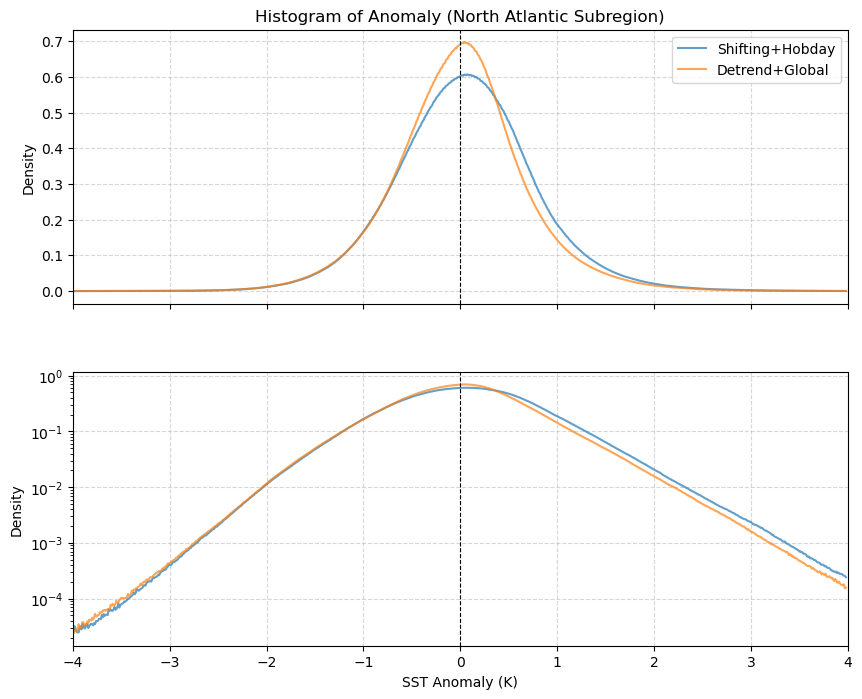

In [7]:
bins = np.arange(-4, 4, 0.01)
# Focus on North Atlantic subregion
lat_slice = slice(45, 55)
lon_slice = slice(-20, 0)

dat_shifting = extremes_ds_shifting.dat_anomaly.sel(lat=lat_slice, lon=lon_slice).data
dat_anomaly = extremes_ds_detrend.dat_anomaly.sel(lat=lat_slice, lon=lon_slice).data

hist_shifting, _ = da.histogram(dat_shifting, bins=bins, density=True)
hist_detrend, _ = da.histogram(dat_anomaly, bins=bins, density=True)

hist_shifting_computed, hist_detrend_computed = dask.compute(hist_shifting, hist_detrend)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={"hspace": 0.25})

axes[0].plot(bins[:-1], hist_shifting_computed, label="Shifting+Hobday", alpha=0.7)
axes[0].plot(bins[:-1], hist_detrend_computed, label="Detrend+Global", alpha=0.7)
axes[0].set_ylabel("Density")
axes[0].set_title("Histogram of Anomaly (North Atlantic Subregion)")
axes[0].set_xlim(-4, 4)
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].axvline(0, color="black", linestyle="--", linewidth=0.8)
axes[0].legend()

axes[1].plot(bins[:-1], hist_shifting_computed, label="Shifting+Hobday", alpha=0.7)
axes[1].plot(bins[:-1], hist_detrend_computed, label="Detrend+Global", alpha=0.7)
axes[1].set_xlabel("SST Anomaly (K)")
axes[1].set_ylabel("Density")
axes[1].set_xlim(-4, 4)
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].set_yscale("log")
axes[1].axvline(0, color="black", linestyle="--", linewidth=0.8)

plt.tight_layout()
plt.show()

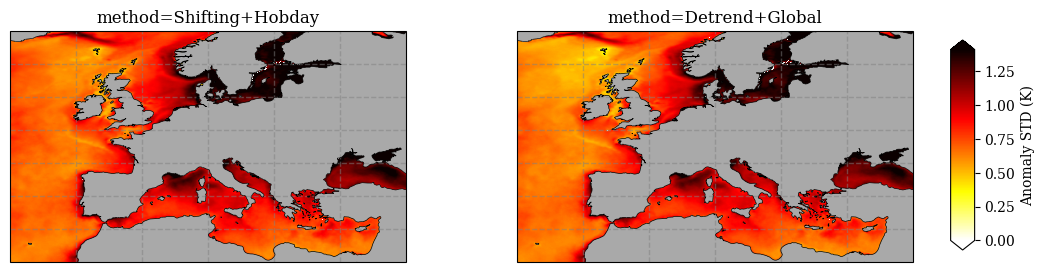

In [7]:
shifting_variance = extremes_ds_shifting.dat_anomaly.std(dim="time")
detrend_variance = extremes_ds_detrend.dat_anomaly.std(dim="time")

config = marEx.PlotConfig(var_units="Anomaly STD (K)", cmap="hot_r", cperc=[0, 96], grid_labels=True, projection=ccrs.PlateCarree())

combined_variance = xr.concat([shifting_variance, detrend_variance], dim="method")
combined_variance = combined_variance.assign_coords(method=["Shifting+Hobday", "Detrend+Global"])

fig, axes = combined_variance.plotX.multi_plot(config, col="method", col_wrap=2)

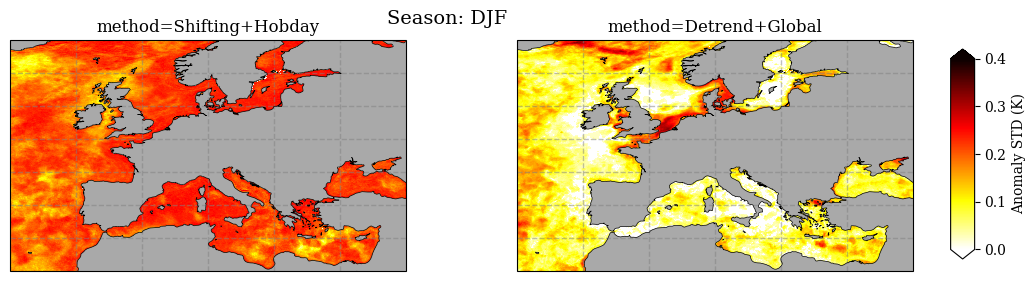

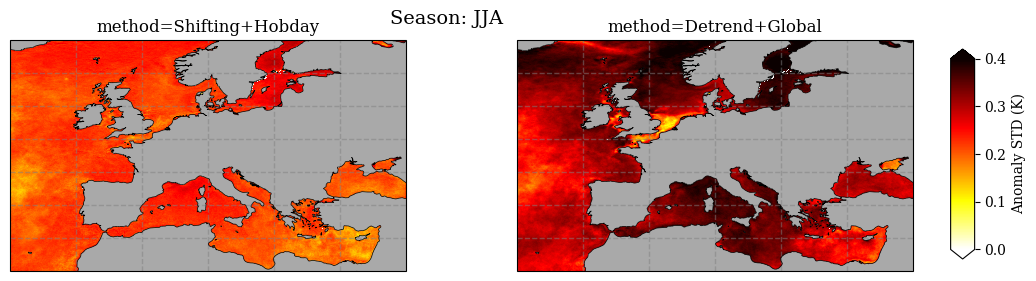

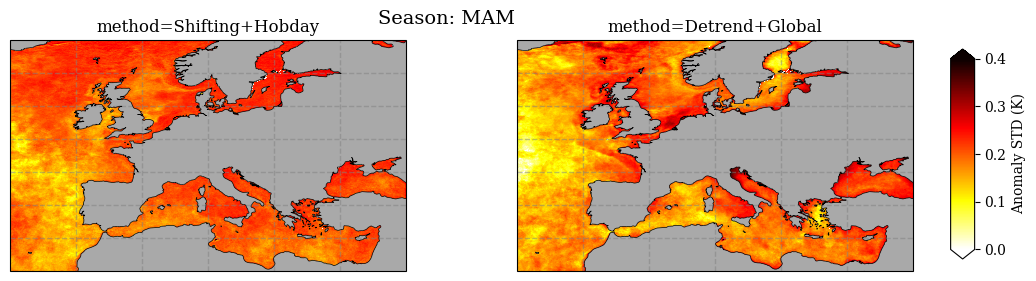

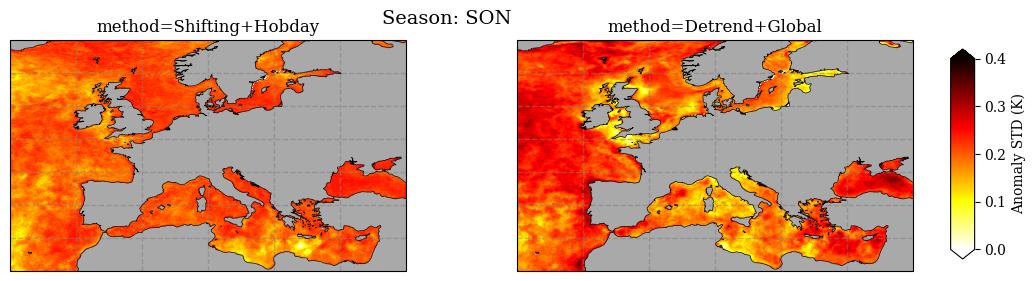

In [8]:
shifting_seasonal_std = extremes_ds_shifting.extreme_events.groupby("time.season").std(dim="time").persist()
detrend_seasonal_std = extremes_ds_detrend.extreme_events.groupby("time.season").std(dim="time").persist()

# Add method coordinate and concatenate
shifting_seasonal_std = shifting_seasonal_std.expand_dims({"method": ["Shifting+Hobday"]})
detrend_seasonal_std = detrend_seasonal_std.expand_dims({"method": ["Detrend+Global"]})
combined_seasonal_std = xr.concat([shifting_seasonal_std, detrend_seasonal_std], dim="method")

config = marEx.PlotConfig(
    var_units="Anomaly STD (K)",
    cmap="hot_r",
    clim=[0, 0.4],
    grid_labels=False,
    show_colorbar=True,
    projection=ccrs.PlateCarree()
)

seasons = combined_seasonal_std["season"].values

for season in seasons:
    data = combined_seasonal_std.sel(season=season)
    fig, axes = data.plotX.multi_plot(config, col="method", col_wrap=2)
    fig.suptitle(f"Season: {season}", fontsize=14)
    plt.show()

## Regional Extreme Event Frequency
N.B.: Hobday definition by construction ensures extremes are relative to that time of year. The seasonal pattern in the harmonic detrended data therefore arises from the aharmonic shape of the seasonal cycle (cf. above timeseries).

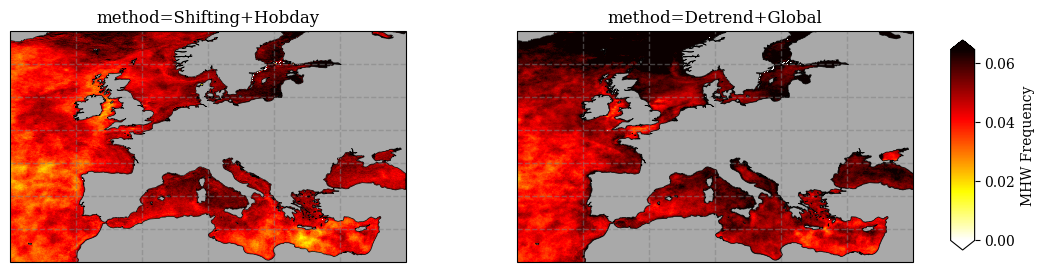

In [9]:
shifting_frequency = extremes_ds_shifting.extreme_events.mean(dim="time")
detrend_frequency = extremes_ds_detrend.extreme_events.mean(dim="time")

config = marEx.PlotConfig(var_units="MHW Frequency", cmap="hot_r", cperc=[0, 96], grid_labels=True, projection=ccrs.PlateCarree())

combined_frequency = xr.concat([shifting_frequency, detrend_frequency], dim="method")
combined_frequency = combined_frequency.assign_coords(method=["Shifting+Hobday", "Detrend+Global"])

fig, axes = combined_frequency.plotX.multi_plot(config, col="method", col_wrap=2)

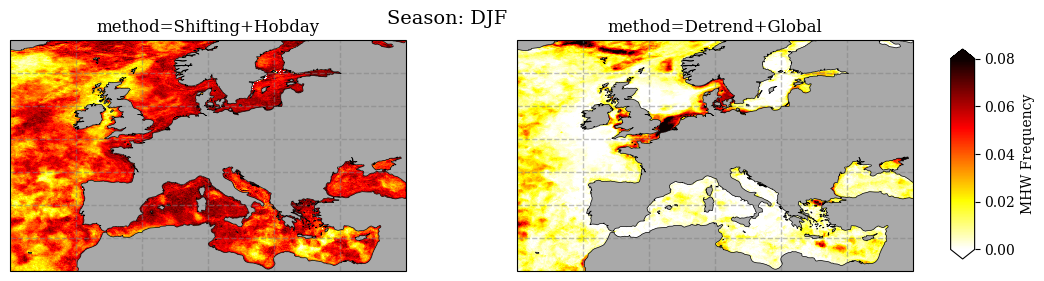

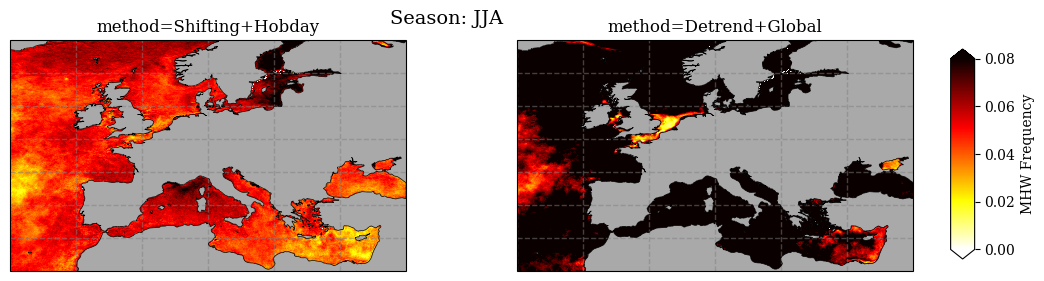

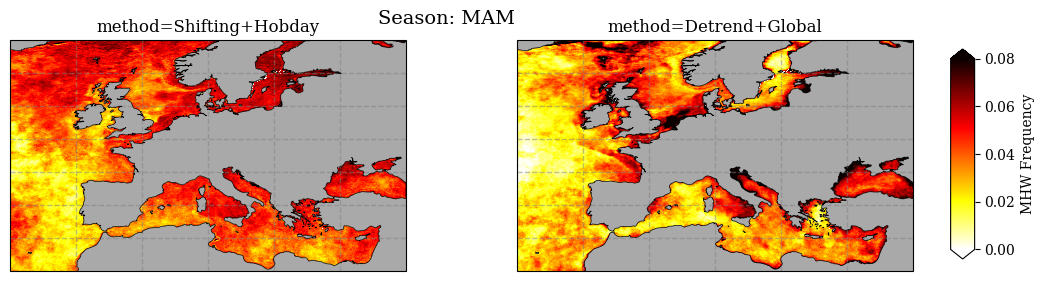

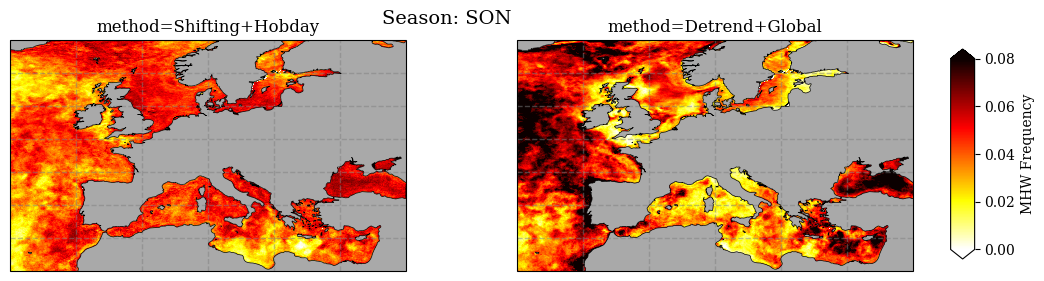

In [10]:
shifting_seasonal_frequency = extremes_ds_shifting.extreme_events.groupby("time.season").mean(dim="time").persist()
detrend_seasonal_frequency = extremes_ds_detrend.extreme_events.groupby("time.season").mean(dim="time").persist()

# Add method coordinate and concatenate
shifting_seasonal_frequency = shifting_seasonal_frequency.expand_dims({"method": ["Shifting+Hobday"]})
detrend_seasonal_frequency = detrend_seasonal_frequency.expand_dims({"method": ["Detrend+Global"]})
combined_seasonal_frequency = xr.concat([shifting_seasonal_frequency, detrend_seasonal_frequency], dim="method")

config = marEx.PlotConfig(
    var_units="MHW Frequency",
    cmap="hot_r",
    clim=[0, 0.08],
    grid_labels=False,
    show_colorbar=True,
    projection=ccrs.PlateCarree()
)

seasons = combined_seasonal_frequency["season"].values

for season in seasons:
    data = combined_seasonal_frequency.sel(season=season)
    fig, axes = data.plotX.multi_plot(config, col="method", col_wrap=2)
    fig.suptitle(f"Season: {season}", fontsize=14)
    plt.show()

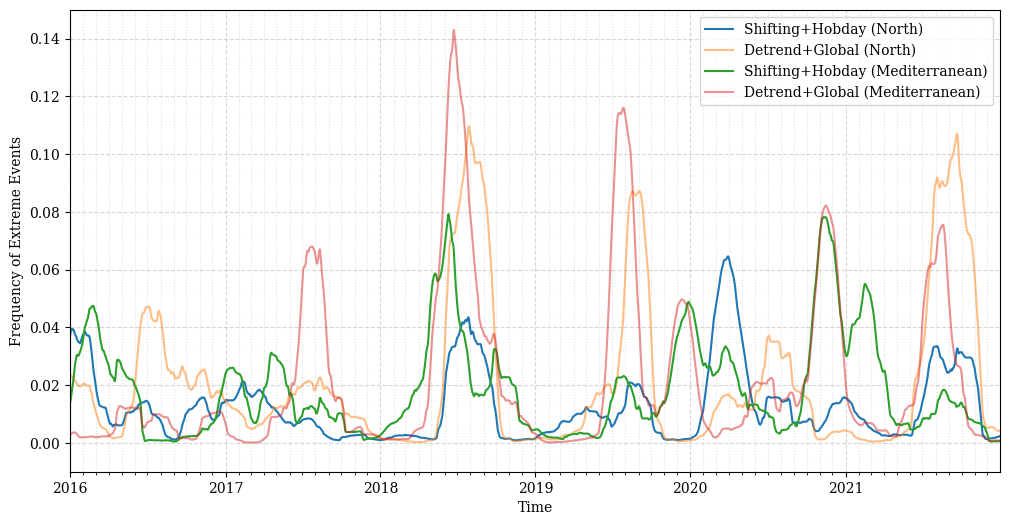

In [16]:
# Regional analysis: North Atlantic vs Mediterranean
monthly_shifting_north = extremes_ds_shifting.extreme_events.sel(lat=slice(50, 65)).mean(dim=["lat", "lon"]).rolling(time=60).mean()
monthly_detrend_north = extremes_ds_detrend.extreme_events.sel(lat=slice(50, 65)).mean(dim=["lat", "lon"]).rolling(time=60).mean()

# Mediterranean region
monthly_shifting_med = extremes_ds_shifting.extreme_events.sel(lat=slice(30, 49)).sel(lon=slice(0,40)).mean(dim=["lat", "lon"]).rolling(time=60).mean()
monthly_detrend_med = extremes_ds_detrend.extreme_events.sel(lat=slice(30, 49)).sel(lon=slice(0,40)).mean(dim=["lat", "lon"]).rolling(time=60).mean()

plt.figure(figsize=(12, 6))
plt.plot(
    monthly_shifting_north.time,
    monthly_shifting_north,
    label="Shifting+Hobday (North)",
)
plt.plot(
    monthly_detrend_north.time,
    monthly_detrend_north,
    label="Detrend+Global (North)",
    alpha=0.5,
)
plt.plot(
    monthly_shifting_med.time,
    monthly_shifting_med,
    label="Shifting+Hobday (Mediterranean)",
)
plt.plot(
    monthly_detrend_med.time,
    monthly_detrend_med,
    label="Detrend+Global (Mediterranean)",
    alpha=0.5,
)
plt.grid(True, which="major", linestyle="--", alpha=0.5)
plt.grid(True, which="minor", linestyle=":", alpha=0.4, axis="x")
plt.xlabel("Time")
plt.ylabel("Frequency of Extreme Events")
plt.xlim(np.datetime64("2016-01-01"), np.datetime64("2021-12-31"))
plt.ylim(-0.01, 0.15)
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(2, 13)))
plt.legend()
plt.show()

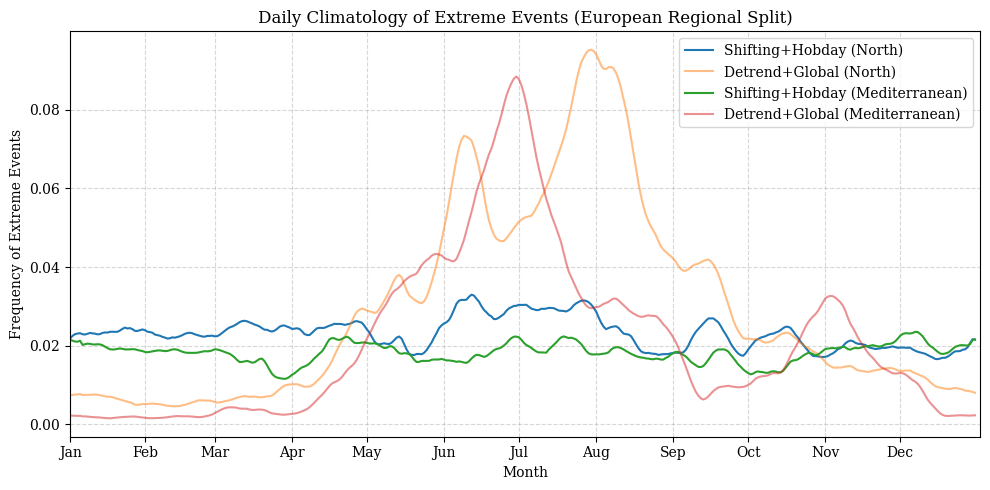

In [17]:
# Daily climatology split by European regions
monthly_shifting_north = (
    extremes_ds_shifting.extreme_events.sel(lat=slice(50, 65))
    .mean(dim=["lat", "lon"])
    .rolling(time=10, center=True)
    .mean("time")
    .groupby("time.dayofyear")
    .mean(dim="time")
    .isel(dayofyear=slice(0, -2))
)
monthly_shifting_med = (
    extremes_ds_shifting.extreme_events.sel(lat=slice(30, 49)).sel(lon=slice(0,40))
    .mean(dim=["lat", "lon"])
    .rolling(time=10, center=True)
    .mean("time")
    .groupby("time.dayofyear")
    .mean(dim="time")
    .isel(dayofyear=slice(0, -2))
)
monthly_detrend_north = (
    extremes_ds_detrend.extreme_events.sel(lat=slice(50, 65))
    .mean(dim=["lat", "lon"])
    .rolling(time=10, center=True)
    .mean("time")
    .groupby("time.dayofyear")
    .mean(dim="time")
    .isel(dayofyear=slice(0, -2))
)
monthly_detrend_med = (
    extremes_ds_detrend.extreme_events.sel(lat=slice(30, 49)).sel(lon=slice(0,40))
    .mean(dim=["lat", "lon"])
    .rolling(time=10, center=True)
    .mean("time")
    .groupby("time.dayofyear")
    .mean(dim="time")
    .isel(dayofyear=slice(0, -2))
)

days = monthly_shifting_north.dayofyear.values
month_starts = [1] + list(np.cumsum([calendar.monthrange(2001, m)[1] for m in range(1, 12)]))
month_labels = [calendar.month_abbr[m] for m in range(1, 13)]

plt.figure(figsize=(10, 5))
plt.plot(days, monthly_shifting_north, label="Shifting+Hobday (North)")
plt.plot(days, monthly_detrend_north, label="Detrend+Global (North)", alpha=0.5)
plt.plot(days, monthly_shifting_med, label="Shifting+Hobday (Mediterranean)")
plt.plot(days, monthly_detrend_med, label="Detrend+Global (Mediterranean)", alpha=0.5)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlabel("Month")
plt.ylabel("Frequency of Extreme Events")
plt.title("Daily Climatology of Extreme Events (European Regional Split)")
plt.legend()

plt.xticks(month_starts, month_labels)
plt.xlim(1, 366)
plt.tight_layout()
plt.show()